# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-UseModel/blob/main/ConvertOCTImagesToHistology.ipynb) and run.
https://github.com/WinetraubLab/OCT2Hist-UseModel/blob/main/ConvertOCTImagesToHistology.ipynb
## Notebook's Inputs:

In [46]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/cropped image.png"

#how many microns per pixel for each axis
microns_per_pixel_z = 1
microns_per_pixel_x = 1

# Path to a folder in drive to output the converted H&E images, leave blank if
# you don't want to save H&E image to drive.
histology_output_image_folder = ""

##verify inputs:

In [47]:
#pix2pix input sizes
VIRTUAL_HIST_WIDTH = 256
VIRTUAL_HIST_HEIGHT = 256
#verify input sizes
MICRONS_PER_PIXEL_Z_TARGET = 1
MICRONS_PER_PIXEL_X_TARGET = 2

Image at target x/z rate is smaller than (256,256), and will be placed at top left corner.


# Set Up Environment
Clone repository and install dependencies:

In [50]:
import os

# Clone repository
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel

base_folder = "/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix"

# Install dependencies
!pip install -r {base_folder}/requirements.txt

# Clean up this window once install is complete
from IPython.display import clear_output
clear_output()

Copy model weights from google drive

In [51]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# This is the folder that the pre-trained model is in
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Model (Paper V2)"

# Copy model to this folder over
!mkdir {base_folder}/checkpoints
!mkdir {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_G.pth" {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_D.pth" {base_folder}/checkpoints/pix2pix/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints’: File exists
mkdir: cannot create directory ‘/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints/pix2pix/’: File exists


# Preprocess
Mask images, crop and convert to the right size

Text(0.5, 1.0, 'Original OCT image ((324, 253, 3))')

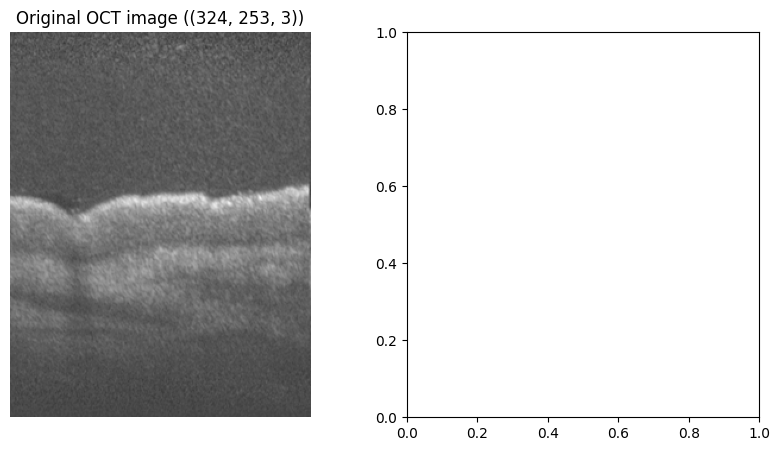

In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load OCT image
oct_image_orig = cv2.imread(oct_input_image_path)
oct_image_orig = cv2.cvtColor(oct_image_orig, cv2.COLOR_BGR2RGB)
oct_image = oct_image_orig.copy()
# Show Images to user
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
oct_image_orig_shape = oct_image.shape
axes[0].imshow(oct_image)
axes[0].axis("off")
axes[0].set_title(f"Original OCT image ({oct_image_orig_shape})")



In [ ]:
#update the image to be 2mic/pix on the x axis, and 1mic/pix on the y axis.
new_image_width = oct_image.shape[1] * microns_per_pixel_x / MICRONS_PER_PIXEL_X_TARGET
new_image_height = oct_image.shape[0] * microns_per_pixel_z / MICRONS_PER_PIXEL_Z_TARGET

if new_image_width<VIRTUAL_HIST_WIDTH or VIRTUAL_HIST_HEIGHT<256:
  print(f"Image at target x/z rate is smaller than ({VIRTUAL_HIST_HEIGHT},{VIRTUAL_HIST_WIDTH}), and will be placed at top left corner.")
#warn about cropping
if new_image_width>VIRTUAL_HIST_WIDTH or new_image_height>VIRTUAL_HIST_HEIGHT:
  raise Exception(f"Image at target x/z rate is too large: ({new_image_height},{new_image_width}), please adjust so that it won't be larger than ({VIRTUAL_HIST_HEIGHT},{VIRTUAL_HIST_WIDTH}).")

In [53]:
%cd /content/OCT2Hist-UseModel

/content/OCT2Hist-UseModel


In [54]:
from utils.masking_utils import mask_image
img, mid = mask_image(oct_image)

#visualize user input to processed input

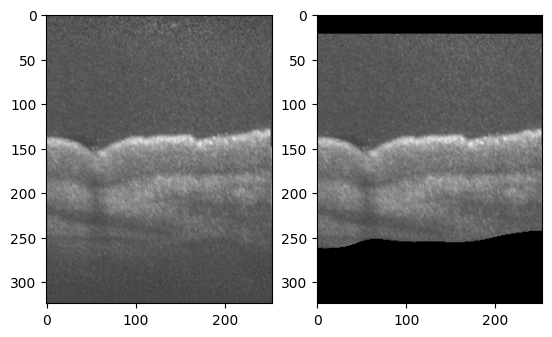

In [66]:
from utils.img_utils import showTwoImgs
#visualize
showTwoImgs(oct_image, img)

In [55]:
# top_row = max(mid - 128, 0)
# bottom_row = min(mid + 128, height)

# cropped_img = img[top_row:bottom_row, :, :]

In [62]:
target_rate_img = cv2.resize(img, (new_image_width, new_image_height), interpolation=cv2.INTER_AREA)
o2h_input = np.zeros((VIRTUAL_HIST_HEIGHT,VIRTUAL_HIST_WIDTH, 3),dtype=np.uint8)
o2h_input[:new_image_height, :new_image_width,:] = target_rate_img

#visualize user input to o2h input

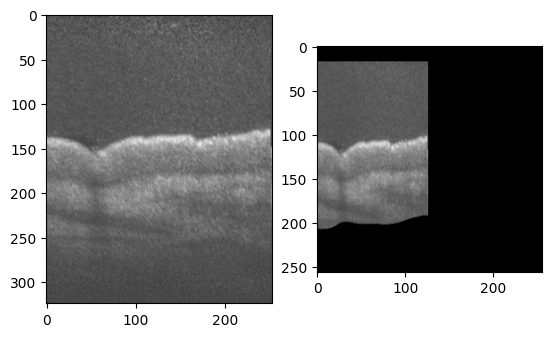

In [64]:
from utils.img_utils import showTwoImgs
#visualize
showTwoImgs(oct_image, o2h_input)

In [ ]:
# Perform pre-process
oct_image_preprocessed = o2h_input

# Show image to user
oct_image_preprocessed_shape = oct_image_preprocessed.shape
axes[1].imshow(oct_image)
axes[1].axis("off")
axes[1].set_title(f"Preprocessed OCT image ({oct_image_preprocessed_shape})")
plt.show()

Format image the way that pix2pix code likes it

In [ ]:
# Create a folder and place OCT image
!mkdir {base_folder}/dataset
!mkdir {base_folder}/dataset/test/

# Before writting image to file, check size
if oct_image_preprocessed.shape[:2] != (256, 256):
        raise ValueError("Image size must be 256x256 pixels to run model on.")

# Padd image and write it to the correct place
padded = np.zeros([256,512,3], np.uint8)
padded[:,:256,:] = oct_image_preprocessed[:,:,:]
cv2.imwrite(f"{base_folder}/dataset/test/im1.jpg", padded)

# Run Model

In [ ]:
!python {base_folder}/test.py --netG resnet_9blocks --dataroot "{base_folder}/dataset/"  --model pix2pix --name pix2pix --checkpoints_dir "{base_folder}/checkpoints" --results_dir "{base_folder}/results"

# Show results

In [ ]:
# Load the virtual histology image
histology_image = cv2.imread(f"{base_folder}/results/pix2pix/test_latest/images/im1_fake_B.png")
histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)

# present side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(oct_image)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()
